In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 77.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_set,batch_size=16, shuffle=True)

val_loader = torch.utils.data.DataLoader(validation_set,batch_size=16)

labels ;tensor([3, 5, 9, 5, 0, 0, 9, 2, 2, 4, 8, 7, 7, 9, 8, 5])


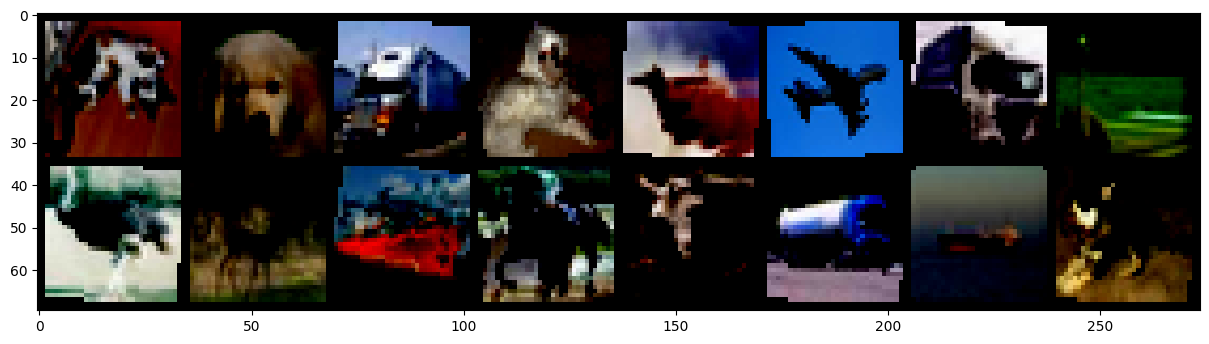

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]

grid = torchvision.utils.make_grid(images[:16],nrow=8)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels ;{labels[:16]}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        means_bn = []
        variances_bn = []

        x = self.conv1(x)
        x = self.bn1(x)
        means_bn.append(torch.mean(x.detach().cpu()).item())
        variances_bn.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        means_bn.append(torch.mean(x.detach().cpu()).item())
        variances_bn.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        means_bn.append(torch.mean(x.detach().cpu()).item())
        variances_bn.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        output = self.fc2(x)

        return means_bn, variances_bn, output

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN_BatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 10

activations_history_means_bn = []
activations_history_variances_bn = []

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for data, target in train_loader:

       data, target = data.to(device), target.to(device)
       optimizer.zero_grad()

       means_bn, variances_bn, output = model(data)

       loss = criterion(output, target)
       loss.backward()
       optimizer.step()

       train_loss += loss.item() * data.size(0)
       _, predicted = torch.max(output.data, 1)
       train_total += target.size(0)
       train_correct += (predicted == target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    activations_history_means_bn.append(means_bn)
    activations_history_variances_bn.append(variances_bn)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f}%')

Epoch: 1 	Training Loss: 1.533534 	Training Accuracy: 43.91%
Epoch: 2 	Training Loss: 1.249884 	Training Accuracy: 55.04%
Epoch: 3 	Training Loss: 1.129297 	Training Accuracy: 59.27%
Epoch: 4 	Training Loss: 1.056052 	Training Accuracy: 62.50%
Epoch: 5 	Training Loss: 0.994744 	Training Accuracy: 64.97%
Epoch: 6 	Training Loss: 0.949513 	Training Accuracy: 66.17%
Epoch: 7 	Training Loss: 0.914510 	Training Accuracy: 67.37%
Epoch: 8 	Training Loss: 0.883455 	Training Accuracy: 68.82%
Epoch: 9 	Training Loss: 0.856581 	Training Accuracy: 69.83%
Epoch: 10 	Training Loss: 0.831163 	Training Accuracy: 70.64%


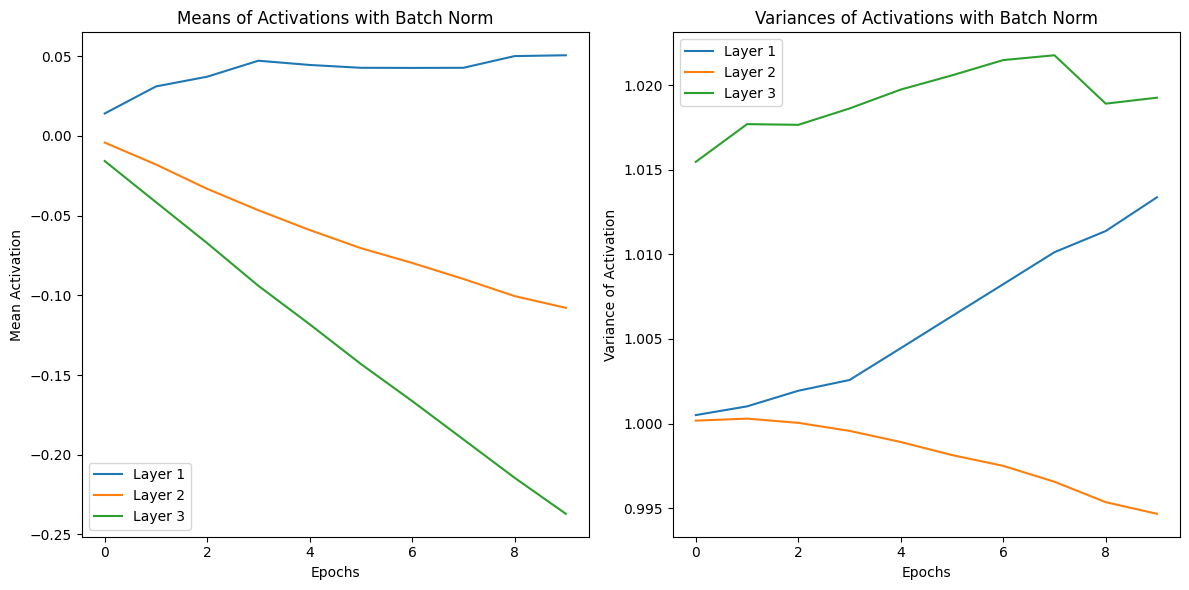

In [ ]:
means_np_bn = np.array(activations_history_means_bn)
variances_np_bn = np.array(activations_history_variances_bn)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(means_np_bn.shape[1]):
    plt.plot(means_np_bn[:, i], label=f'Layer {i+1}')
plt.title('Means of Activations with Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Mean Activation')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(variances_np_bn.shape[1]):
    plt.plot(variances_np_bn[:, i], label=f'Layer {i+1}')
plt.title('Variances of Activations with Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Variance of Activation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(activations_history_means_bn)

[[0.01406656950712204, -0.004161166027188301, -0.01576150953769684], [0.031043440103530884, -0.01791168749332428, -0.04154282063245773], [0.037153154611587524, -0.033204834908246994, -0.06726514548063278], [0.04718571901321411, -0.04663790389895439, -0.09406022727489471], [0.04452451318502426, -0.05903546139597893, -0.11816355586051941], [0.0427427776157856, -0.07040978223085403, -0.14309923350811005], [0.04267042875289917, -0.07967479526996613, -0.1663178652524948], [0.04274032264947891, -0.08972617238759995, -0.1903844177722931], [0.05007999390363693, -0.10048878192901611, -0.2144739329814911], [0.05060777813196182, -0.1078685075044632, -0.23708096146583557]]


In [ ]:
print(activations_history_variances_bn)

[[1.0004992485046387, 1.0001716613769531, 1.015465259552002], [1.0010143518447876, 1.0002895593643188, 1.017691969871521], [1.0019370317459106, 1.0000405311584473, 1.0176503658294678], [1.002572774887085, 0.9995657801628113, 1.0186182260513306], [1.0044546127319336, 0.998908281326294, 1.0197341442108154], [1.0063482522964478, 0.9981374740600586, 1.0205740928649902], [1.0082327127456665, 0.9974987506866455, 1.0214765071868896], [1.010124921798706, 0.99656081199646, 1.021761417388916], [1.0113743543624878, 0.995354175567627, 1.0189019441604614], [1.0133678913116455, 0.9946661591529846, 1.019254207611084]]


In [ ]:
class CNN_without_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_without_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        means = []
        variances = []

        x = self.conv1(x)
        means.append(torch.mean(x.detach().cpu()).item())
        variances.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        means.append(torch.mean(x.detach().cpu()).item())
        variances.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        means.append(torch.mean(x.detach().cpu()).item())
        variances.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        output = self.fc2(x)

        return means, variances, output

In [ ]:
model2 = CNN_without_BatchNorm().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

n_epochs = 10
activations_history_means = []
activations_history_variances = []

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model2.train()
    for data, target in train_loader:

       data, target = data.to(device), target.to(device)
       optimizer2.zero_grad()

       means, variances, output = model2(data)

       loss = criterion(output, target)
       loss.backward()
       optimizer2.step()

       train_loss += loss.item() * data.size(0)
       _, predicted = torch.max(output.data, 1)
       train_total += target.size(0)
       train_correct += (predicted == target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    activations_history_means.append(means)
    activations_history_variances.append(variances)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f}%')

Epoch: 1 	Training Loss: 2.025298 	Training Accuracy: 25.79%
Epoch: 2 	Training Loss: 1.616456 	Training Accuracy: 41.00%
Epoch: 3 	Training Loss: 1.451056 	Training Accuracy: 47.56%
Epoch: 4 	Training Loss: 1.338458 	Training Accuracy: 51.81%
Epoch: 5 	Training Loss: 1.254078 	Training Accuracy: 54.92%
Epoch: 6 	Training Loss: 1.185263 	Training Accuracy: 57.76%
Epoch: 7 	Training Loss: 1.125547 	Training Accuracy: 59.90%
Epoch: 8 	Training Loss: 1.080852 	Training Accuracy: 61.78%
Epoch: 9 	Training Loss: 1.038430 	Training Accuracy: 63.13%
Epoch: 10 	Training Loss: 1.006872 	Training Accuracy: 64.11%


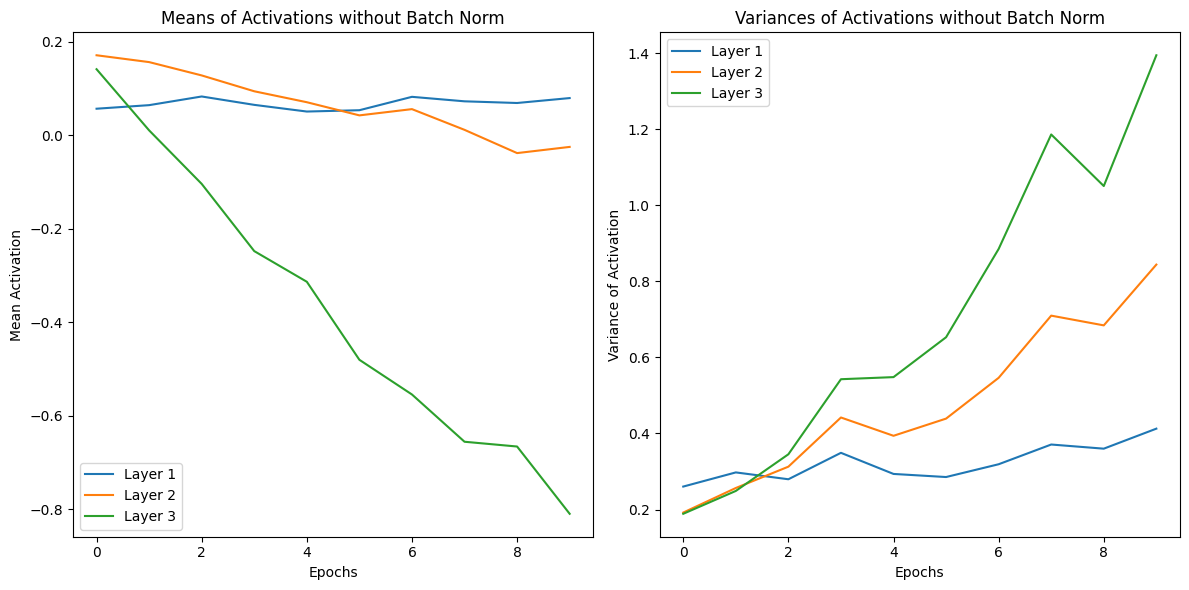

In [ ]:
means_np = np.array(activations_history_means)
variances_np = np.array(activations_history_variances)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(means_np.shape[1]):
    plt.plot(means_np[:, i], label=f'Layer {i+1}')
plt.title('Means of Activations without Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Mean Activation')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(variances_np.shape[1]):
    plt.plot(variances_np[:, i], label=f'Layer {i+1}')
plt.title('Variances of Activations without Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Variance of Activation')
plt.legend()

plt.tight_layout()
plt.show()

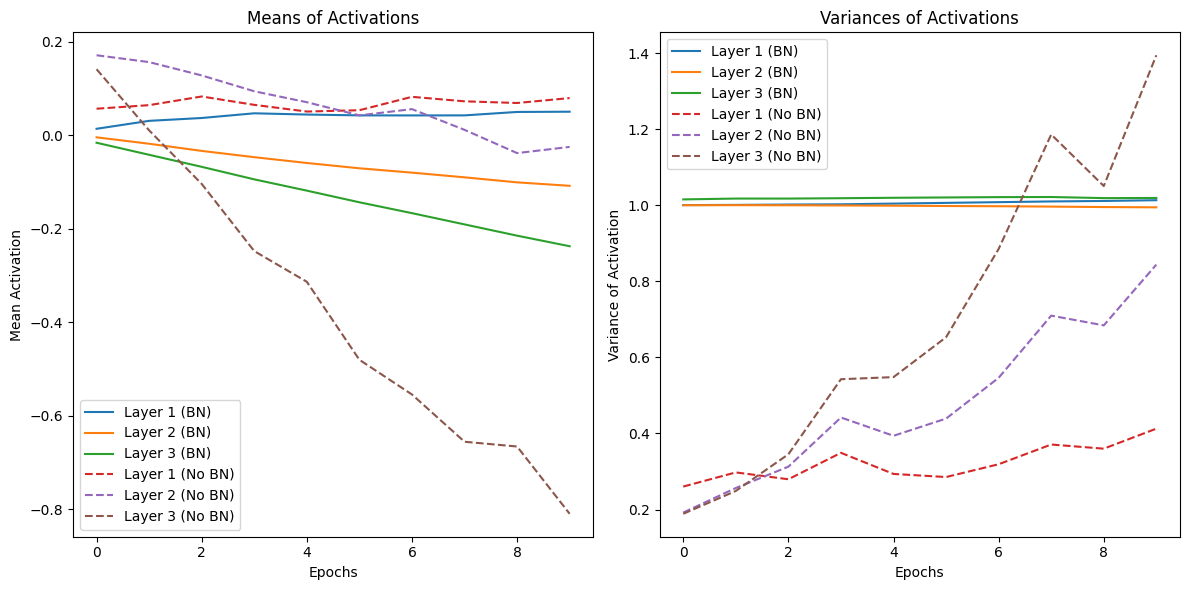

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
for i in range(means_np_bn.shape[1]):
    plt.plot(means_np_bn[:, i], label=f'Layer {i+1} (BN)')
for i in range(means_np.shape[1]):
    plt.plot(means_np[:, i], label=f'Layer {i+1} (No BN)', linestyle='--')
plt.title('Means of Activations')
plt.xlabel('Epochs')
plt.ylabel('Mean Activation')
plt.legend()


plt.subplot(1, 2, 2)
for i in range(variances_np_bn.shape[1]):
    plt.plot(variances_np_bn[:, i], label=f'Layer {i+1} (BN)', linestyle='-')
for i in range(variances_np.shape[1]):
    plt.plot(variances_np[:, i], label=f'Layer {i+1} (No BN)', linestyle='--')
plt.title('Variances of Activations')
plt.xlabel('Epochs')
plt.ylabel('Variance of Activation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN_Noisy_BatchNorm(nn.Module):
    def __init__(self, n_mu=0.5, n_sigma=1.25, r_mu=0.1, r_sigma=0.1):
        super(CNN_Noisy_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

        self.n_mu = n_mu
        self.n_sigma = n_sigma
        self.r_mu = r_mu
        self.r_sigma = r_sigma

    def add_noise(self, x):
        mu_t = torch.FloatTensor(1).uniform_(-self.n_mu, self.n_mu).to(x.device)
        sigma_t = torch.FloatTensor(1).uniform_(1, self.n_sigma).to(x.device)

        mu_t = mu_t.item()
        sigma_t = sigma_t.item()

        m_t = torch.FloatTensor(x.size()).uniform_(mu_t - self.r_mu, mu_t + self.r_mu).to(x.device)
        s_t = torch.FloatTensor(x.size()).normal_(sigma_t, self.r_sigma).to(x.device)

        return s_t * x + m_t

    def forward(self, x):
        noisy_means = []
        noisy_variances = []

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.add_noise(x)
        noisy_means.append(torch.mean(x.detach().cpu()).item())
        noisy_variances.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.add_noise(x)
        noisy_means.append(torch.mean(x.detach().cpu()).item())
        noisy_variances.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.add_noise(x)
        noisy_means.append(torch.mean(x.detach().cpu()).item())
        noisy_variances.append(torch.var(x.detach().cpu()).item())
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        output = self.fc2(x)

        return noisy_means, noisy_variances, output

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model3 = CNN_Noisy_BatchNorm(n_mu=0.5, n_sigma=1.25, r_mu=0.1, r_sigma=0.1).to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)

n_epochs = 10
activations_history_means_noisy = []
activations_history_variances_noisy = []

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model3.train()
    for data, target in train_loader:

       data, target = data.to(device), target.to(device)
       optimizer3.zero_grad()

       means_noisy, variances_noisy, output = model3(data)

       loss = criterion(output, target)
       loss.backward()
       optimizer3.step()

       train_loss += loss.item() * data.size(0)
       _, predicted = torch.max(output.data, 1)
       train_total += target.size(0)
       train_correct += (predicted == target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    activations_history_means_noisy.append(means_noisy)
    activations_history_variances_noisy.append(variances_noisy)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f}%')

Epoch: 1 	Training Loss: 1.587893 	Training Accuracy: 41.72%
Epoch: 2 	Training Loss: 1.317988 	Training Accuracy: 52.66%
Epoch: 3 	Training Loss: 1.200485 	Training Accuracy: 56.96%
Epoch: 4 	Training Loss: 1.108747 	Training Accuracy: 60.32%
Epoch: 5 	Training Loss: 1.051381 	Training Accuracy: 62.69%
Epoch: 6 	Training Loss: 0.999072 	Training Accuracy: 64.79%
Epoch: 7 	Training Loss: 0.959841 	Training Accuracy: 65.98%
Epoch: 8 	Training Loss: 0.932004 	Training Accuracy: 67.12%
Epoch: 9 	Training Loss: 0.902570 	Training Accuracy: 68.22%
Epoch: 10 	Training Loss: 0.880154 	Training Accuracy: 69.09%


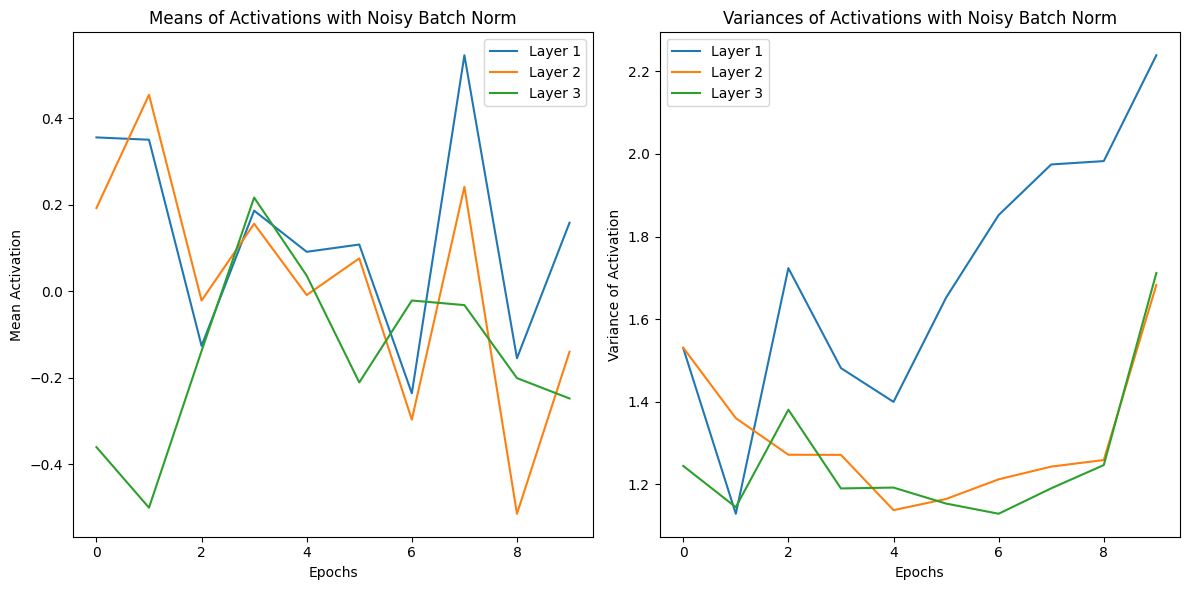

In [ ]:
means_np_noisy = np.array(activations_history_means_noisy)
variances_np_noisy = np.array(activations_history_variances_noisy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(means_np_noisy.shape[1]):
    plt.plot(means_np_noisy[:, i], label=f'Layer {i+1}')
plt.title('Means of Activations with Noisy Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Mean Activation')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(variances_np_noisy.shape[1]):
    plt.plot(variances_np_noisy[:, i], label=f'Layer {i+1}')
plt.title('Variances of Activations with Noisy Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Variance of Activation')
plt.legend()

plt.tight_layout()
plt.show()

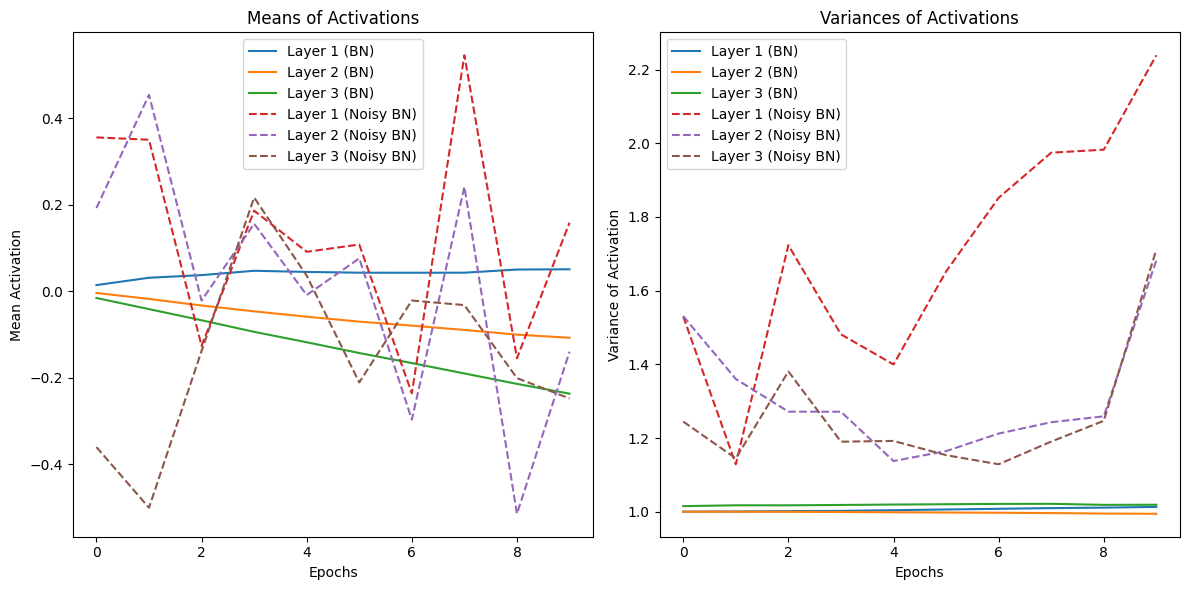

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
for i in range(means_np_bn.shape[1]):
    plt.plot(means_np_bn[:, i], label=f'Layer {i+1} (BN)')
for i in range(means_np_noisy.shape[1]):
    plt.plot(means_np_noisy[:, i], label=f'Layer {i+1} (Noisy BN)', linestyle='--')
plt.title('Means of Activations')
plt.xlabel('Epochs')
plt.ylabel('Mean Activation')
plt.legend()


plt.subplot(1, 2, 2)
for i in range(variances_np_bn.shape[1]):
    plt.plot(variances_np_bn[:, i], label=f'Layer {i+1} (BN)', linestyle='-')
for i in range(variances_np_noisy.shape[1]):
    plt.plot(variances_np_noisy[:, i], label=f'Layer {i+1} (Noisy BN)', linestyle='--')
plt.title('Variances of Activations')
plt.xlabel('Epochs')
plt.ylabel('Variance of Activation')
plt.legend()

plt.tight_layout()
plt.show()

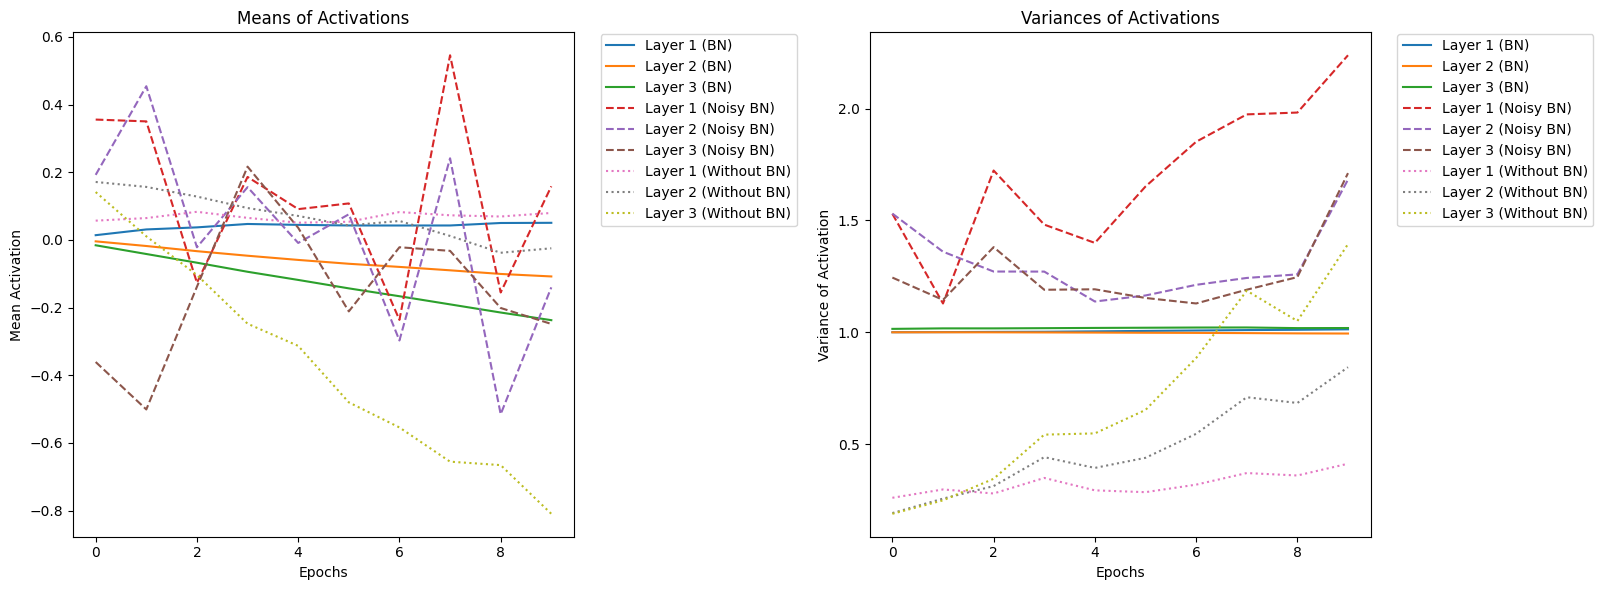

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for i in range(means_np_bn.shape[1]):
    plt.plot(means_np_bn[:, i], label=f'Layer {i+1} (BN)', linestyle='-')
for i in range(means_np_noisy.shape[1]):
    plt.plot(means_np_noisy[:, i], label=f'Layer {i+1} (Noisy BN)', linestyle='--')
for i in range(means_np.shape[1]):
    plt.plot(means_np[:, i], label=f'Layer {i+1} (Without BN)', linestyle=':')
plt.title('Means of Activations')
plt.xlabel('Epochs')
plt.ylabel('Mean Activation')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.1)

plt.subplot(1, 2, 2)
for i in range(variances_np_bn.shape[1]):
    plt.plot(variances_np_bn[:, i], label=f'Layer {i+1} (BN)', linestyle='-')
for i in range(variances_np_noisy.shape[1]):
    plt.plot(variances_np_noisy[:, i], label=f'Layer {i+1} (Noisy BN)', linestyle='--')
for i in range(variances_np.shape[1]):
    plt.plot(variances_np[:, i], label=f'Layer {i+1} (Without BN)', linestyle=':')
plt.title('Variances of Activations')
plt.xlabel('Epochs')
plt.ylabel('Variance of Activation')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.1)

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show()